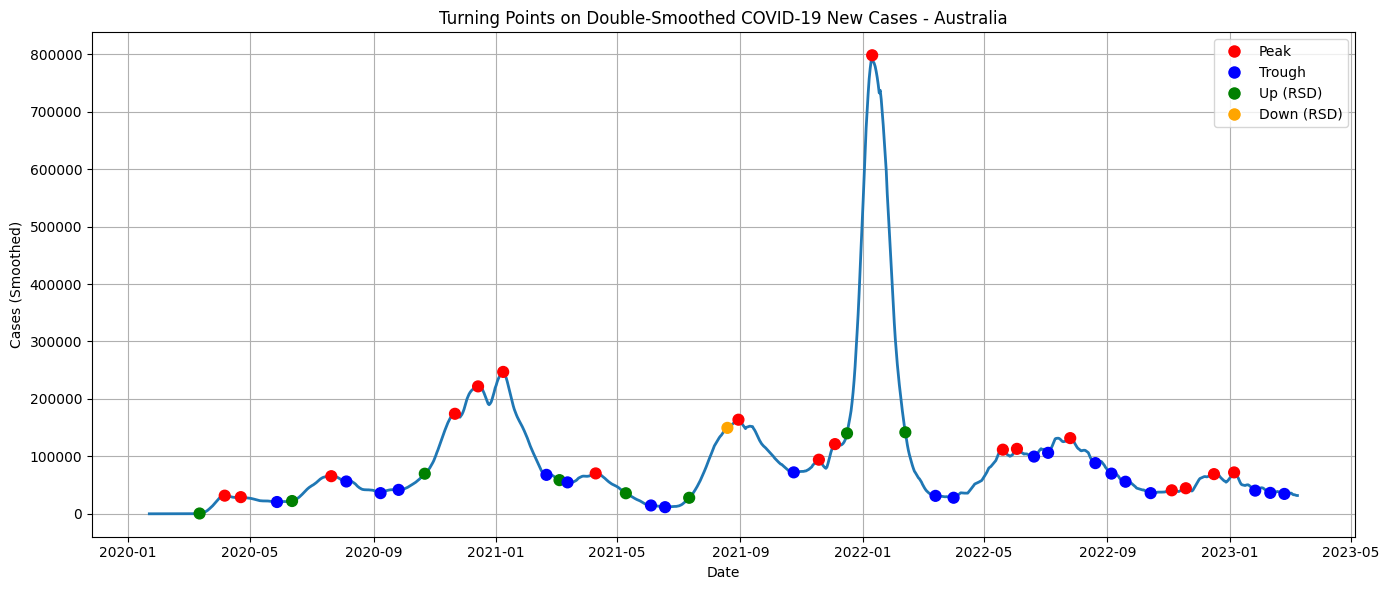

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.metrics.combined_tp_extraction import extract_combined_turning_points

# === Load data ===
data = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])
data = data[data["country"] == "US"].copy()
data.set_index("date", inplace=True)

# === Apply double smoothing ===
series = data["new_cases"].fillna(0)
smoothed = series.rolling(7, center=True, min_periods=1).mean()
smoothed = smoothed.rolling(7, center=True, min_periods=1).mean()

# === Extract turning points ===
tp_df = extract_combined_turning_points(series)
tp_df["date"] = smoothed.index[tp_df["index"]].values
tp_df.set_index("date", inplace=True)

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(smoothed, label="Double-smoothed new_cases", linewidth=2)
plt.scatter(tp_df.index, smoothed.loc[tp_df.index], 
            c=tp_df["type"].map({
                "peak": "red", 
                "trough": "blue", 
                "up": "green", 
                "down": "orange"
            }),
            label="Turning Points", s=60, zorder=5)

# Custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Peak', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Trough', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Up (RSD)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Down (RSD)', markerfacecolor='orange', markersize=10)
]
plt.legend(handles=handles)
plt.title("Turning Points on Double-Smoothed COVID-19 New Cases - Australia")
plt.xlabel("Date")
plt.ylabel("Cases (Smoothed)")
plt.grid(True)
plt.tight_layout()
plt.show()


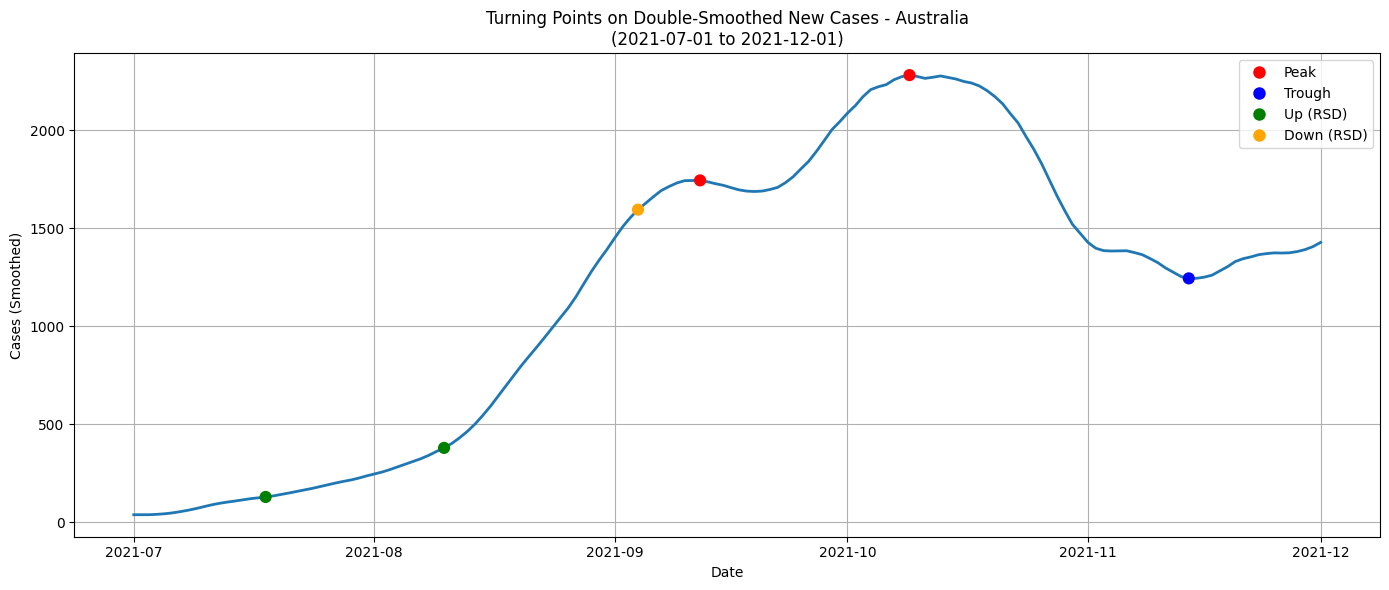

In [5]:
# === Parameters ===
start_date = "2021-07-01"
end_date = "2021-12-01"

# === Restrict to date range ===
smoothed_range = smoothed.loc[start_date:end_date]
tp_df_range = tp_df.loc[start_date:end_date]

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(smoothed_range, label="Double-smoothed new_cases", linewidth=2)
plt.scatter(tp_df_range.index, smoothed.loc[tp_df_range.index], 
            c=tp_df_range["type"].map({
                "peak": "red", 
                "trough": "blue", 
                "up": "green", 
                "down": "orange"
            }),
            label="Turning Points", s=60, zorder=5)

# Custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Peak', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Trough', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Up (RSD)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Down (RSD)', markerfacecolor='orange', markersize=10)
]
plt.legend(handles=handles)
plt.title(f"Turning Points on Double-Smoothed New Cases - Australia\n({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Cases (Smoothed)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import json
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.metrics.combined_tp_extraction import extract_combined_turning_points
from src.metrics.tp_window_metrics import compute_tp_alignment_errors  # new function for TP-date-aligned metrics

# === Load and process raw data ===
data = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])
data = data[data["country"] == "Australia"].copy()
data.set_index("date", inplace=True)

# === Extract turning points from the ground truth ===
series = data["new_cases"].fillna(0).copy()
tp_df = extract_combined_turning_points(series)
tp_df["date"] = series.index[tp_df["index"]].values
tp_df.set_index("date", inplace=True)

# === Load forecast results ===
forecast_df = pd.read_csv("../results/arima/Australia/7/death_all/forecast_results.csv")

# === Compute TP-date alignment errors ===
alignment_metrics_df = compute_tp_alignment_errors(forecast_df, tp_df)
#alignment_metrics_df.to_csv("tp_alignment_metrics_Australia.csv", index=False)
print(alignment_metrics_df.head())





           MAE          RMSE       sMAPE     MAE_mean  MAE_median     MAE_25p  \
0  4431.820963  10558.592815  113.032377  4431.820963  1799.00215  837.729303   

       MAE_75p      MAE_std     MAE_min       MAE_max  ...     RMSE_std  \
0  5456.719217  6048.217079  272.595951  39090.480129  ...  8484.936874   

     RMSE_min     RMSE_max  sMAPE_mean  sMAPE_median  sMAPE_25p   sMAPE_75p  \
0  346.540972  49550.62999  113.032377    119.748302  38.597456  182.722832   

   sMAPE_std  sMAPE_min  sMAPE_max  
0  70.379404   8.096899      200.0  

[1 rows x 24 columns]


In [9]:
import pandas as pd
import json
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.metrics.combined_tp_extraction import extract_combined_turning_points
from src.metrics.tp_slope_direction import compute_tp_and_global_slope_agreement  # new function for TP-date-aligned metrics

# === Load and process raw data ===
data = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])
data = data[data["country"] == "Australia"].copy()
data.set_index("date", inplace=True)

# === Extract turning points from the ground truth ===
series = data["new_cases"].fillna(0).copy()
smoothed = series.rolling(7, center=True, min_periods=1).mean()
smoothed = smoothed.rolling(7, center=True, min_periods=1).mean()

tp_df = extract_combined_turning_points(series)
tp_df["date"] = series.index[tp_df["index"]].values
tp_df.set_index("date", inplace=True)

# === Load forecast results ===
forecast_df = pd.read_csv("../results/arima/Australia/7/death_all/forecast_results.csv")

slope_agreement_df = compute_tp_and_global_slope_agreement(forecast_df, tp_df, series)
print(slope_agreement_df)

   tp_same_sign  tp_diff_sign  tp_diff_percentage  \
0            95            66               40.99   

                                 tp_slope_diff_stats  global_same_sign  \
0  (73.44832004425783, 32.93457038408227, 0.29183...               778   

   global_diff_sign  global_diff_percentage  \
0               359                   31.57   

                             global_slope_diff_stats  
0  (54.59836735920732, 19.358778238744424, 0.1473...  


In [2]:
import pandas as pd
import json
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.metrics.combined_tp_extraction import extract_combined_turning_points
from src.metrics.tp_lead_lag_error import compute_tp_lead_lag

# === Load and process raw data ===
data = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])
data = data[data["country"] == "Australia"].copy()
data.set_index("date", inplace=True)

# === Extract turning points from the ground truth ===
series = data["new_cases"].fillna(0).copy()
smoothed = series.rolling(7, center=True, min_periods=1).mean()
smoothed = smoothed.rolling(7, center=True, min_periods=1).mean()

tp_df = extract_combined_turning_points(series)
tp_df["date"] = series.index[tp_df["index"]].values
tp_df.set_index("date", inplace=True)

# === Load forecast results ===
forecast_df = pd.read_csv("../results/lstm/Australia/14_7/death_all/forecast_results.csv")

lead_lag_df = compute_tp_lead_lag(forecast_df, tp_df, series)
print(lead_lag_df)

      tp_date tp_type  matched matched_date  lead_lag_days
0  2022-07-21    peak    False          NaT            NaN
1  2022-07-21    peak    False          NaT            NaN
2  2022-07-21    peak    False          NaT            NaN
3  2022-07-21    peak    False          NaT            NaN
4  2022-08-20      up    False          NaT            NaN
..        ...     ...      ...          ...            ...
76 2023-03-02    peak     True   2023-03-01           -1.0
77 2023-03-02    peak     True   2023-03-03            1.0
78 2023-03-02    peak     True   2023-03-05            3.0
79 2023-03-02    peak     True   2023-03-07            5.0
80 2023-03-02    peak    False          NaT            NaN

[81 rows x 5 columns]


In [8]:
import numpy as np
matched = lead_lag_df[lead_lag_df['matched']]['lead_lag_days']
np.abs(matched).std()

1.5833895626542784